In [1]:
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.filter import match
from pycbc.waveform import get_td_waveform
import lal

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

################################################################################
#
#    PLOTTING OPTIONS
#
################################################################################


# PLOTTING OPTIONS
fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]

params = { 'axes.labelsize': 24,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'figure.figsize': fig_size}

mpl.rcParams.update(params)

In [3]:
!echo $PYTHONPATH

/Users/wyf/projects/eccsearch/eccwaveform:/Users/wyf/projects/teobresums/Python:/Users/wyf/1-Ongoing-Project/13-eccentric-TEOB-xisco/2.Code/IMRPhenomDE:/Users/wyf/Gwaves/lscsoft/src/TaylorF2e/:/Users/wyf/99-GWcode/TEOBResumS/Python:


# Validating the validation paper

In [4]:
import sxs
from pycbc.types import TimeSeries
class sxswave(object):
    '''
    A class to encapsulate SXS waveform reading and plotting.
    At the moment only return h22 and sliced waveform starting from the reference time
    '''
    def __init__(self,sxsid,ext_order=4):
        #load the data and metadata.json
        self.hlm = sxs.load("SXS:BBH:"+str(sxsid)+"/Lev/rhOverM", extrapolation_order=ext_order)
        self.metadata = sxs.load("SXS:BBH:"+str(sxsid)+"/Lev/metadata.json")

        # time slide the 0 time point to the maximum norm position
        # self.max_norm_time = self.hlm.max_norm_time()
        # AttributeError: can't set attribute
        
        # chop off the junk radiation
        self.reference_index = self.hlm.index_closest_to(self.metadata.reference_time)
        self.hlm_sliced = self.hlm[self.reference_index:]
        
        # Only consider the h22 mode in this work, left the higher mode to future
        self.h22 = self.hlm_sliced[:, self.hlm.index(2, 2)]
        
    def hphc(self,theta,phi):
        '''
        Evaluate h+ - ihx = hlm -2Ylm(theta,phi)
        '''
        return self.hlm_sliced.evaluate(theta, phi)
    
    def h22_pycbcts(self):
        t_start = self.h22.t[0]
        t_end = self.h22.t[-1]
        #print(t_start,t_end)
        dt = np.min(np.diff(self.h22.t))
        t_uniform = np.arange(t_start, t_end, dt)
        h = self.h22.interpolate(t_uniform)
        return TimeSeries(h.data, delta_t=dt,epoch = -dt*np.argmax(np.abs(h.data)))
    
    def h22_pycbcts_phyunit(self,**kwargs):
        
        mtotal = kwargs['mass1'] + kwargs['mass2']
        distance = kwargs['distance']
        amp_factor = distance*1e6*lal.PC_SI / mtotal /lal.MRSUN_SI
        time_factor = 1/ mtotal /lal.MTSUN_SI

        t_start = self.h22.t[0]
        t_end = self.h22.t[-1]
        dt = np.min(np.diff(self.h22.t))
        if dt / time_factor < kwargs['delta_t']:
            dt  = time_factor * kwargs['delta_t']
        else:
            raise ValueError("dt (in physics unit) larger than the delta_t required")
        t_uniform = np.arange(t_start, t_end, dt)
        h = self.h22.interpolate(t_uniform)
        return TimeSeries(h.data / amp_factor, delta_t=dt / time_factor,\
                          epoch = -dt*np.argmax(np.abs(h.data)) / time_factor)

In [5]:
nr_wf = sxswave(1362)

kwargs = {'mass1':10,
          'mass2':10,
          'spin1z':0,
          'spin2z':0,
          'f_lower':20,
          'delta_t':1/4096,
          'distance':400,
          'long_acs_nodes':0,
          'coa_phase':0}

nr_h22_phyunit = nr_wf.h22_pycbcts_phyunit(**kwargs)

Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer
Found the following files to load from the SXS catalog:
    SXS:BBH:1362v5/Lev5/rhOverM_Asymptotic_GeometricUnits_CoM.h5
Found the following files to load from the SXS catalog:
    SXS:BBH:1362v5/Lev5/metadata.json


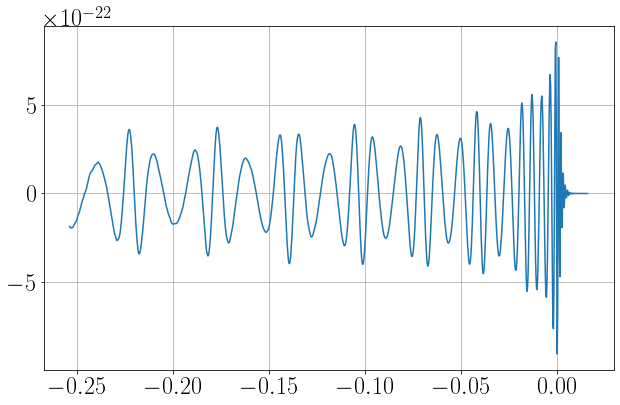

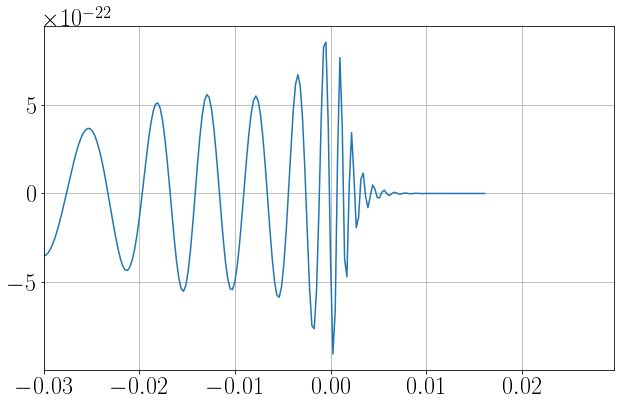

In [6]:
plt.plot(nr_h22_phyunit.sample_times,np.real(nr_h22_phyunit.data.data))
plt.show()

plt.plot(nr_h22_phyunit.sample_times,np.real(nr_h22_phyunit.data.data))
plt.xlim(-0.03,)
plt.show()

# NR waveform parameters, especially initial frequency,spin

In [7]:
mtotal = kwargs['mass1']+kwargs['mass2']
time_factor = 1/ mtotal /lal.MTSUN_SI
print('initial frequency is:', nr_wf.metadata['initial_orbital_frequency'] * time_factor)

initial frequency is: 113.88419110645222


In [8]:
print('spin1 is :', nr_wf.metadata['reference_dimensionless_spin1'])
print('spin2 is :', nr_wf.metadata['reference_dimensionless_spin2'])

spin1 is : [-1.83985610931e-08, -3.3802957018e-09, 1.21703736618e-05]
spin2 is : [2.0295334932e-08, 2.8149471693e-09, 1.20317126489e-05]


# Generating h22 of SEOBNRE

In [31]:
ecc=0.59
hp,hc = get_td_waveform(approximant='SEOBNRE',**kwargs,eccentricity=ecc)

#construct h22
seobh22 = TimeSeries((hp.data - 1j*hc.data) / lal.SpinWeightedSphericalHarmonic(0,0,-2,2,2),\
                 delta_t=hp.delta_t ,\
                 epoch = -np.argmax(np.abs(hp.data - 1j*hc.data))* hp.delta_t )

In [36]:
flow = 20
# Generate the aLIGO ZDHP PSD
delta_f = 1.0 / seobh22.duration
flen = tlen//2 + 1
psd = aLIGOZeroDetHighPower(flen, delta_f, flow)

m, i = match(hp, hp, psd=psd, low_frequency_cutoff=flow)

print('The match between SEOBNRv4 and TEOBResumSecc is: {:.4f}'.format(m))
print('i is',i)


The match between SEOBNRv4 and TEOBResumSecc is: 1.0000
i is 0


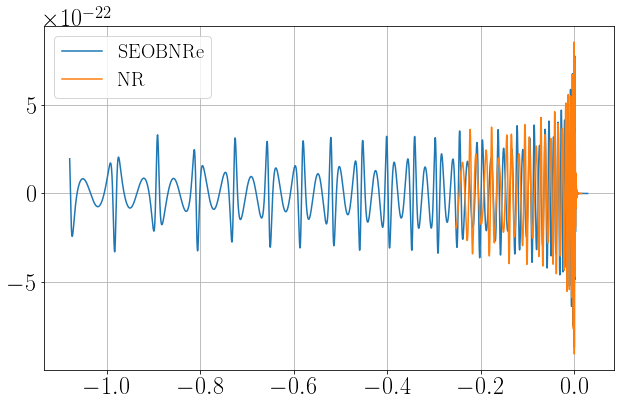

In [10]:
plt.plot(seobh22.sample_times,np.real(seobh22.data.data),label='SEOBNRe')
plt.plot(nr_h22_phyunit.sample_times,np.real(nr_h22_phyunit.data.data),label='NR')
#plt.xlim(-300,200)
plt.legend()

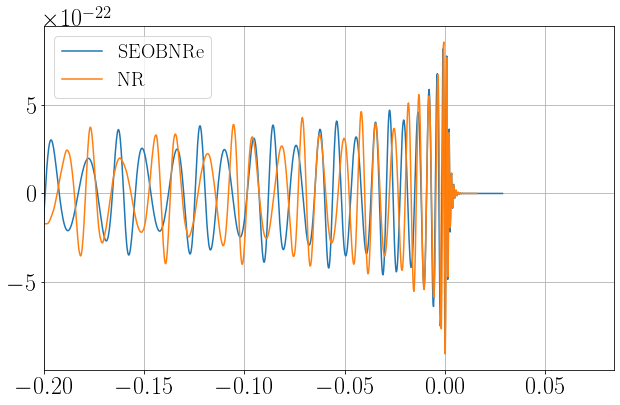

In [11]:
plt.plot(seobh22.sample_times,np.real(seobh22.data.data),label='SEOBNRe')
plt.plot(nr_h22_phyunit.sample_times,np.real(nr_h22_phyunit.data.data),label='NR')
plt.xlim(-0.2,)
plt.legend()

# Match

In [13]:
print('length of SEOBNRe is: ',len(seobh22))
print('length of NR is: ',len(nr_h22_phyunit))
# Resize the waveforms to the same length

tstart = max(seobh22.start_time,nr_h22_phyunit.start_time)
tend = min(seobh22.end_time,nr_h22_phyunit.end_time)
print('start time of seobh22 is: ',seobh22.start_time)
print('start time of nr is : ',nr_h22_phyunit.start_time)

#seobh22 = seobh22.time_slice(tstart,tend)
#nr_h22_phyunit = nr_h22_phyunit.time_slice(tstart,tend)

length of SEOBNRe is:  4539
length of NR is:  1106
start time of seobh22 is:  -1.079101562
start time of nr is :  -0.253662109


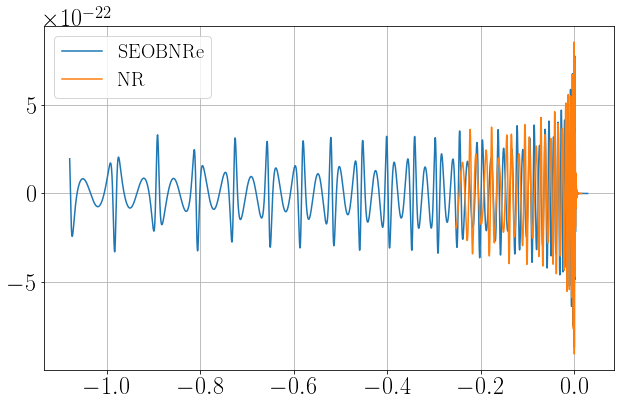

In [14]:
plt.plot(seobh22.sample_times,np.real(seobh22.data.data),label='SEOBNRe')
plt.plot(nr_h22_phyunit.sample_times,np.real(nr_h22_phyunit.data.data),label='NR')
#plt.xlim(-300,200)
plt.legend()

In [23]:
flow = nr_wf.metadata['initial_orbital_frequency'] * time_factor

tlen = max(len(seobh22),len(nr_h22_phyunit))
seobh22.resize(tlen)
nr_h22_phyunit.resize(tlen)

# Generate the aLIGO ZDHP PSD
delta_f = 1.0 / seobh22.duration
flen = tlen//2 + 1
psd = aLIGOZeroDetHighPower(flen, delta_f, flow)



In [24]:
seobh22.duration

1.108154296875

In [25]:
nr_h22_phyunit.duration

1.108154296875

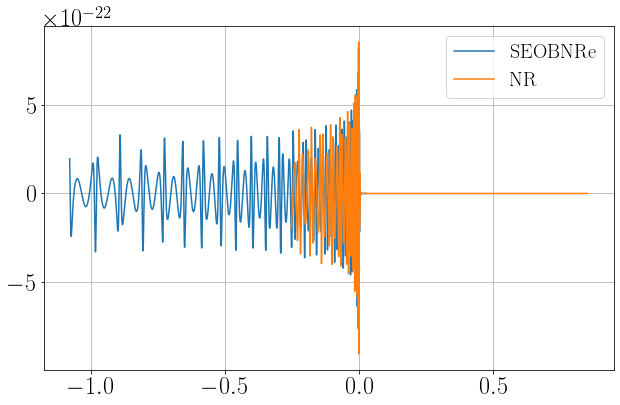

In [26]:
plt.plot(seobh22.sample_times,np.real(seobh22.data.data),label='SEOBNRe')
plt.plot(nr_h22_phyunit.sample_times,np.real(nr_h22_phyunit.data.data),label='NR')
#plt.xlim(-300,200)
plt.legend()

In [27]:
psd

In [29]:
# Note: This takes a while the first time as an FFT plan is generated
# subsequent calls are much faster.
m, i = match(seobh22, seobh22, psd=psd, low_frequency_cutoff=flow)

print('The match between SEOBNRv4 and TEOBResumSecc is: {:.4f}'.format(m))
print('i is',i)

ValueError: For C2C FFT, len(outvec) must be nbatch*size

# $h_+  - i h_\times = \sum_{l,m} h_{lm}{}_{-2}Y_{lm}$ 

In [ ]:
kwargs = {'mass1':20,
          'mass2':20,
          'f_lower':20,
          'delta_t':1/4096,
          'distance':400,
          'long_acs_nodes':0}
ecc=0.1

hpeob4,_ = get_td_waveform(approximant='SEOBNRv4',**kwargs)
hpteob,_ = get_td_waveform(approximant='TEOBResumSecc',**kwargs,eccentricity=ecc)
hpeobe,_ = get_td_waveform(approximant='SEOBNRE',**kwargs,eccentricity=ecc)

# Resize the waveforms to the same length
tlen = max(len(hpeob4), len(hpteob),len(hpeobe))
hpeob4.resize(tlen)
hpteob.resize(tlen)
hpeobe.resize(tlen)

# Generate the aLIGO ZDHP PSD
delta_f = 1.0 / hpeob4.duration
flen = tlen//2 + 1
psd = aLIGOZeroDetHighPower(flen, delta_f, kwargs['f_lower'])

# Note: This takes a while the first time as an FFT plan is generated
# subsequent calls are much faster.
m, i = match(hpeob4, hpteob, psd=psd, low_frequency_cutoff=kwargs['f_lower'])
m2, _ = match(hpeob4, hpeobe, psd=psd, low_frequency_cutoff=kwargs['f_lower'])
mmutal, _ = match(hpteob, hpeobe, psd=psd, low_frequency_cutoff=kwargs['f_lower'])
print('The match between SEOBNRv4 and TEOBResumSecc is: {:.4f}'.format(m))
print('The match between SEOBNRv4 and SEOBNRE is: {:.4f}'.format(m2))
print('The match between TEOBResumSecc and SEOBNRE is: {:.4f}'.format(mmutal))
print('i is',i)

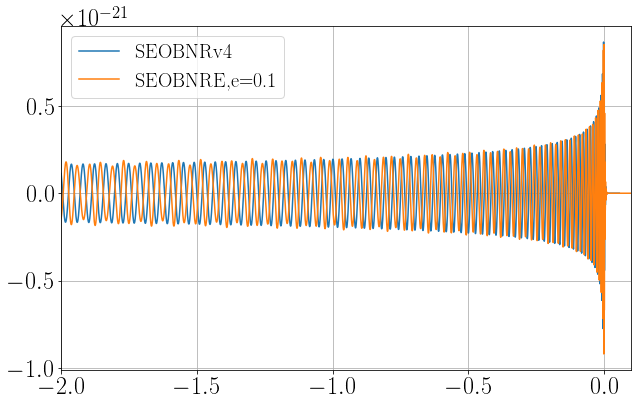

In [4]:
plt.plot(hpeob4.sample_times,hpeob4,label='SEOBNRv4')
#plt.plot(hpteob.sample_times,hpteob,label='TEOBResumSecc,e='+str(ecc))
plt.plot(hpeobe.sample_times,hpeobe,label='SEOBNRE,e='+str(ecc))
plt.xlim(-2,0.1)
plt.legend()

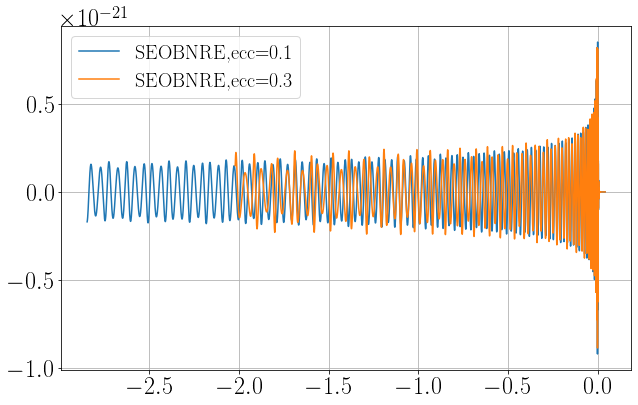

In [5]:
hpeobe1,_ = get_td_waveform(approximant='SEOBNRE',**kwargs,eccentricity=0.1)
hpeobe2,_ = get_td_waveform(approximant='SEOBNRE',**kwargs,eccentricity=0.3)

plt.plot(hpeobe1.sample_times,hpeobe1,label='SEOBNRE,ecc=0.1')
plt.plot(hpeobe2.sample_times,hpeobe2,label='SEOBNRE,ecc=0.3')
plt.legend()

In [6]:
hpteob1,_ = get_td_waveform(approximant='TEOBResumSecc',**kwargs,eccentricity=0.1)
hpteob2,_ = get_td_waveform(approximant='TEOBResumSecc',**kwargs,eccentricity=0.3)

plt.plot(hpeobe1.sample_times,hpeobe1,label='TEOBResumSecc,ecc=0.1')
plt.plot(hpeobe2.sample_times,hpeobe2,label='TEOBResumSecc,ecc=0.3')
plt.legend()